In [3]:
import numpy as np, pandas as pd, time, os, subprocess, scipy as sp, diffmap as dm#, app_utils
#import intviz_coess
# import plotly
import importlib, matplotlib.pyplot as plt, sklearn.covariance as skcov
import scipy.io, tqdm, sklearn.metrics, tqdm, umap
from scipy.sparse import csr_matrix
# import scanpy.api as sc, anndata as adata

_data_path = '/Users/akshay/github/coessentiality-browser/data/'

"""
coess_mat = pd.read_csv(_data_path + 'GLS_p.tsv.gz', sep="\t", index_col=0)
cmat_sav = coess_mat.astype('float32')
np.save(_data_path + 'GLS_p.npy', cmat_sav.values)
np.save(_data_path + 'gene_names.npy', coess_mat.index)
"""
gene_names = np.load(_data_path + 'gene_names.npy')


# Read in GO terms with which to color cells.
"""
# Only a few % are enriched for anything, with 10 main terms (colors).
go_mat = pd.read_csv('GO_terms.tsv.gz', sep="\t", index_col=0).astype(bool)
term_names = go_mat.columns
print("Genes enriched per term: \n" + str(np.sum(go_mat)))

# Uncomment only if we want separately intersected subsets to be different colors.
# term_dict = dict(zip(np.power(2., np.arange(10)), term_names))
# term_dict[544] = 'biological process:translation + cellular component:ribosome''
term_dict = {(i+1): term_names[i] for i in range(len(term_names))}
term_dict[0] = 'none'

# Build array of GO term enrichments for each gene.

term_enrichments = np.zeros(go_mat.shape[0])
for i in range(len(term_enrichments)):
    ndces = np.where(go_mat.values[i,:])[0]
    if len(ndces) == 1:
        term_enrichments[i] = ndces[0]
print(term_enrichments.shape)
"""

'\n# Only a few % are enriched for anything, with 10 main terms (colors).\ngo_mat = pd.read_csv(\'GO_terms.tsv.gz\', sep="\t", index_col=0).astype(bool)\nterm_names = go_mat.columns\nprint("Genes enriched per term: \n" + str(np.sum(go_mat)))\n\n# Uncomment only if we want separately intersected subsets to be different colors.\n# term_dict = dict(zip(np.power(2., np.arange(10)), term_names))\n# term_dict[544] = \'biological process:translation + cellular component:ribosome\'\'\nterm_dict = {(i+1): term_names[i] for i in range(len(term_names))}\nterm_dict[0] = \'none\'\n\n# Build array of GO term enrichments for each gene.\n\nterm_enrichments = np.zeros(go_mat.shape[0])\nfor i in range(len(term_enrichments)):\n    ndces = np.where(go_mat.values[i,:])[0]\n    if len(ndces) == 1:\n        term_enrichments[i] = ndces[0]\nprint(term_enrichments.shape)\n'

In [4]:
import scanpy.api as sc

In [29]:
import json
dct = {'a':3, 't':5}
with open('result.json', 'w') as fp:
    json.dump({ str(k): dct[k] for k in dct }, fp, ensure_ascii=False)
with open("result.json", "r") as read_file:
    dta = json.load(read_file, encoding='ascii')
    new_dct = { str(k): dta[k] for k in dta }

In [33]:
with open('result.json', 'w') as fp:
    json.dump({ }, fp, ensure_ascii=False)

In [34]:
with open("result.json", "r") as read_file:
    dta = json.load(read_file, encoding='ascii')
    new_dct = { str(k): dta[k] for k in dta }
new_dct

{}

In [3]:
pdv = pd.read_csv(app_utils.params['plot_data_df_path'], sep="\t", index_col=False)

# Read raw normalized essentiality data.

In [87]:
data_ess = pd.read_csv(_data_path + 'essentiality.tsv.gz', index_col=0, header=0, sep='\t')
data_ess = data_ess[data_ess.columns[:-4]]   # Only first 481 cols put through GLS, so isolate these
cell_line_names = data_ess.columns
cancer_types = data_ess.columns.str.split('_').str[1:].str.join(' ').str.capitalize().str.replace(
    'Haematopoietic and lymphoid tissue', 'Hematopoietic/lymphoid')
ess_vals = data_ess.values

In [118]:
itime = time.time()
skgl = sklearn.covariance.GraphicalLasso(mode='lars')
# Whiten data
U, s, Vt = np.linalg.svd(ess_vals.T, full_matrices=False)
ess_white = np.dot(U, Vt)
print(time.time() - itime)

0.8430285453796387


In [114]:
# plt.hist(np.std(ess_vals, axis=1), bins=150)
# plt.show()

(481, 17634)

In [88]:
itime = time.time()
skgl.fit(ess_white)
print(time.time() - itime)

3370.251026391983


In [119]:
# Lars
itime = time.time()
skgl.fit(ess_vals.T)
print(time.time() - itime)

OverflowError: int too large to convert to float

In [100]:
newm = skgl.precision_.copy()
for i in range(newm.shape[0]):
    newm[i,i] = 0

In [106]:
ess_white.shape

(481, 17634)

# Read shRNA data

In [300]:
data_shRNA = pd.read_csv(_data_path + 'D2_combined_gene_dep_scores.csv', index_col=0, header=0, sep=',')
gene_to_shRNA = {}
for g in tqdm.tqdm_notebook(gene_names):
    common_shRNA_genes = [x for x in filter(lambda elm: g in elm, data_shRNA.index)]
    if len(common_shRNA_genes) > 0:
        gene_to_shRNA[g] = common_shRNA_genes

In [314]:
ct = 0
for g in gene_to_shRNA:
    if (len(gene_to_shRNA[g]) > 30):
        ct += 1
        print(g)

ADA
AMT
ARC
C1D
C2
C3
C5
C6
C7
C9
CP
CS
F2
F3
F5
F7
FAP
GAL
GC
GPR1
HP
HR
IK
IST1
KL
MAG
MB
NF1
NF2
PC
RP1
SF1
SI
SP1
T
TF
TG
TH
TMEM2
TNF
TPR
TUB
ZNF2
ZNF3
ZNF7


# Read in clusterONE analysis, and index it by gene.

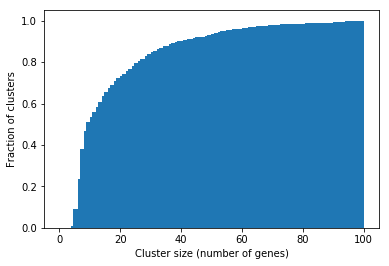

In [6]:
cone_clusts = pd.read_csv(_data_path + 'clusterOne_clusters.tsv', sep="\t", index_col=0, header=0)
"""
clustdata = cone_clusts.iloc[:,10:].fillna(value='')
nclusts = clustdata.shape[0]
cluster_ndces = {}
for gname in tqdm.tqdm_notebook(gene_names):
    cluster_ndces[gname] = np.where(clustdata == gname)[0]
clust_mmships = np.zeros((len(gene_names), nclusts))
for i in range(len(gene_names)):
    clust_mmships[i, cluster_ndces[gene_names[i]]] = 1
clust_mmships = sp.sparse.csr_matrix(clust_mmships)
sp.sparse.save_npz('/users/abalsubr/hodos/coessentiality/data/clusterone_memberships.npz', clust_mmships)
cone_clusts.iloc[:,:10]['Most-enriched GO term'].fillna(_UNKNOWN_PLACEHOLDER).to_csv('/users/abalsubr/hodos/coessentiality/data/clusterone_goterms.txt', index=False, sep='\t')
"""
clust_mmships = sp.sparse.load_npz(_data_path + 'clusterone_memberships.npz')
cluster_sizes = np.sum(clust_mmships.toarray(), axis=0)
plt.hist(cluster_sizes, bins=150, density=True, cumulative=True, range=(0,100))
plt.xlabel("Cluster size (number of genes)")
plt.ylabel("Fraction of clusters")
plt.show()

In [7]:
CO_mmships = { 'orig': sp.sparse.load_npz(_data_path + 'clusterone_memberships.npz') }
for dparam in ['0.2', '0.5', '0.8', '0.9', '0.95', '0.99', 
               '0.8_batch_corrected', '0.9_batch_corrected', '0.95_batch_corrected', '0.99_batch_corrected']:
    CO_mmships[dparam] = sp.sparse.load_npz(_data_path + 'clusterone_memberships_{}.npz'.format(dparam))

# selected_genes = ['A2M', 'ZYX', 'ZZZ3']
selected_genes = np.random.choice(gene_names, 400)
selected_gene_ndces = np.concatenate([np.where(gene_names == x)[0] for x in selected_genes])
cluster_mems = np.squeeze(np.array(clust_mmships[selected_gene_ndces, :].sum(axis=0)))
#clust_mmships.shape

CO_mmships['orig']#.iloc[:,:10]['Most-enriched GO term'].fillna('Unknown')
#np.array(goterms_bycluster)[np.argsort(cluster_mems)[::-1]]

<17634x1892 sparse matrix of type '<class 'numpy.float64'>'
	with 38566 stored elements in Compressed Sparse Row format>

In [90]:
# Build and save pairwise Jaccard similarities between genes, according to each of the clusterings given.
for dparam in ['0.2', '0.5', '0.8', '0.9', '0.95', '0.99', 
               '0.8_batch_corrected', '0.9_batch_corrected', '0.95_batch_corrected', '0.99_batch_corrected']:
    itime = time.time()
    gg_jaccsims = dm.pairwise_jaccard_graph(CO_mmships[dparam])
    sp.sparse.save_npz(_data_path + 'gg_CO_d_{}_jaccard.npz'.format(dparam), gg_jaccsims)

/Users/akshay/github/coessentiality-browser/old_code/diffmap_coess.py:201: RuntimeWarning: divide by zero encountered in true_divide
  return sp.sparse.csr_matrix(np.nan_to_num(np.divide(a, tmp)))
/Users/akshay/github/coessentiality-browser/old_code/diffmap_coess.py:201: RuntimeWarning: invalid value encountered in true_divide
  return sp.sparse.csr_matrix(np.nan_to_num(np.divide(a, tmp)))


In [94]:
for dparam in ['0.2', '0.5', '0.8', '0.9', '0.95', '0.99', 
               '0.8_batch_corrected', '0.9_batch_corrected', '0.95_batch_corrected', '0.99_batch_corrected']:
    gm_inc = dm.build_knn(gg_jaccsims, k=10, symmetrize_type='inclusive')
    sp.sparse.save_npz(_data_path + 'CO_d_{}_10NN.npz'.format(dparam), gm_inc)


/miniconda3/lib/python3.6/site-packages/scipy/sparse/compressed.py:746: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  SparseEfficiencyWarning)


In [8]:
GLS_pvals_10 = sp.sparse.load_npz(_data_path + 'GLS_pvals_10NN.npz')
import anndata as adata

In [12]:
itime = time.time()
for dparam in ['0.2', '0.5', '0.8', '0.9', '0.95', '0.99', '0.8_batch_corrected', '0.9_batch_corrected', '0.95_batch_corrected', '0.99_batch_corrected']:
    gm_inc = sp.sparse.load_npz(_data_path + 'CO_d_{}_10NN.npz'.format(dparam))
    adj_mat = sp.sparse.csr_matrix((0.99 * gm_inc) + (0.01 * GLS_pvals_10))
    n_cmps = 100
    reduced_dim = 50
    vizdf_filename = _data_path + "vizdf_GLS01_CO99_d_{}.csv".format(dparam)

    # Create different eigenmaps: unweighted naive, and weighted diffmap
#     emap_naive, eigvals = dm.diffmap_proj(adj_mat, t=0, n_comps=reduced_dim, embed_type='naive', return_eigvals=True)
#     print("Laplacian eigenmap computed. Time: {}".format(time.time() - itime))
    emap_heat = dm.diffmap_proj(adj_mat, n_comps=n_cmps, n_dims=reduced_dim, min_energy_frac=0.9, embed_type='diffmap', return_eigvals=False)
    print("Diffusion components computed. Time: {}".format(time.time() - itime))
    
#     ann_naive = adata.AnnData(X=emap_naive[:, :40])
    ann_heat = adata.AnnData(X=emap_heat[:, :40])
#     sc.tl.tsne(ann_heat, use_rep='X')#, perplexity=30)
#     print(time.time() - itime)
#     sc.tl.tsne(ann_naive, use_rep='X')
#     print(time.time() - itime)
    
    sc.pp.neighbors(ann_heat)
    print(time.time() - itime)
    
    itime = time.time()
    sc.tl.umap(ann_heat)
    #heat_umap = umap.UMAP().fit_transform(ann_heat.X)
    heat_umap = ann_heat.obsm['X_umap']
    print(time.time() - itime)
    
#     naive_dm = emap_naive[:, :3].copy()
#     naive_tSNE = np.array(ann_naive.obsm['X_tsne'])
#     heat_dm = emap_heat[:, :3].copy()
#     heat_tSNE = np.array(ann_heat.obsm['X_tsne'])

    vizdf = pd.DataFrame(data=heat_umap, #np.hstack((# naive_dm, naive_tSNE, heat_dm, heat_tSNE, )), 
                         columns=[
#                              'EM_x', 'EM_y', 'EM_z', 'tSNE_x', 'tSNE_y', 'hEM_x', 'hEM_y', 'hEM_z', 'htSNE_x', 'htSNE_y', 
                             'hUMAP_x', 'hUMAP_y'], dtype='object')
    vizdf['gene_names'] = gene_names
    vizdf.to_csv(vizdf_filename, sep="\t", index=False)

51 dimensions contain about 0.8999999999999998 fraction of the variance in the first 100 dimensions (Diffusion time = 155.6653804096707)
Diffusion components computed. Time: 15.168089866638184
20.453459978103638


/miniconda3/lib/python3.6/site-packages/umap/spectral.py:229: UserWarning: Embedding a total of 70 separate connected components using meta-embedding (experimental)
  n_components


12.268049001693726
51 dimensions contain about 0.8999999999999999 fraction of the variance in the first 100 dimensions (Diffusion time = 155.66538040969303)
Diffusion components computed. Time: 27.431121110916138
33.23143005371094


/miniconda3/lib/python3.6/site-packages/umap/spectral.py:229: UserWarning: Embedding a total of 70 separate connected components using meta-embedding (experimental)
  n_components


12.962638139724731
51 dimensions contain about 0.9000000000000001 fraction of the variance in the first 100 dimensions (Diffusion time = 155.66538040966924)
Diffusion components computed. Time: 28.345037937164307
34.07413387298584


/miniconda3/lib/python3.6/site-packages/umap/spectral.py:229: UserWarning: Embedding a total of 70 separate connected components using meta-embedding (experimental)
  n_components


12.312243223190308
51 dimensions contain about 0.8999999999999999 fraction of the variance in the first 100 dimensions (Diffusion time = 155.66538040968618)
Diffusion components computed. Time: 27.369946002960205
33.28055214881897


/miniconda3/lib/python3.6/site-packages/umap/spectral.py:229: UserWarning: Embedding a total of 70 separate connected components using meta-embedding (experimental)
  n_components


21.131593942642212
51 dimensions contain about 0.9000000000000001 fraction of the variance in the first 100 dimensions (Diffusion time = 155.66538040967473)
Diffusion components computed. Time: 44.323161125183105
66.82862687110901


/miniconda3/lib/python3.6/site-packages/umap/spectral.py:229: UserWarning: Embedding a total of 70 separate connected components using meta-embedding (experimental)
  n_components


30.95576500892639
51 dimensions contain about 0.9000000000000001 fraction of the variance in the first 100 dimensions (Diffusion time = 155.66538040968368)
Diffusion components computed. Time: 46.190778970718384
53.436131954193115


/miniconda3/lib/python3.6/site-packages/umap/spectral.py:229: UserWarning: Embedding a total of 70 separate connected components using meta-embedding (experimental)
  n_components


16.490745782852173
51 dimensions contain about 0.9000000000000001 fraction of the variance in the first 100 dimensions (Diffusion time = 155.66538040971824)
Diffusion components computed. Time: 30.61316990852356
38.08199191093445


/miniconda3/lib/python3.6/site-packages/umap/spectral.py:229: UserWarning: Embedding a total of 70 separate connected components using meta-embedding (experimental)
  n_components


17.658421993255615
51 dimensions contain about 0.8999999999999999 fraction of the variance in the first 100 dimensions (Diffusion time = 155.66538040968524)
Diffusion components computed. Time: 31.50100016593933
38.75009608268738


/miniconda3/lib/python3.6/site-packages/umap/spectral.py:229: UserWarning: Embedding a total of 70 separate connected components using meta-embedding (experimental)
  n_components


15.411038875579834
51 dimensions contain about 0.8999999999999999 fraction of the variance in the first 100 dimensions (Diffusion time = 155.66538040968493)
Diffusion components computed. Time: 29.07588291168213
36.47861099243164


/miniconda3/lib/python3.6/site-packages/umap/spectral.py:229: UserWarning: Embedding a total of 70 separate connected components using meta-embedding (experimental)
  n_components


13.728508949279785
51 dimensions contain about 0.9000000000000002 fraction of the variance in the first 100 dimensions (Diffusion time = 155.66538040965943)
Diffusion components computed. Time: 27.410481929779053
35.75217008590698


/miniconda3/lib/python3.6/site-packages/umap/spectral.py:229: UserWarning: Embedding a total of 70 separate connected components using meta-embedding (experimental)
  n_components


26.129020929336548


In [10]:
itime = time.time()
sc.tl.umap(ann_heat)
print(time.time() - itime)

/miniconda3/lib/python3.6/site-packages/umap/spectral.py:229: UserWarning: Embedding a total of 70 separate connected components using meta-embedding (experimental)
  n_components


12.765801906585693


In [35]:
itime = time.time()
from umap.umap_ import find_ab_params, simplicial_set_embedding
from sklearn.utils import check_random_state
X_umap = dm.umap_embed_inplace(ann_heat)
ann_heat.obsm['X_umap'] = X_umap
print(time.time() - itime)

AttributeError: module 'diffmap_coess' has no attribute 'umap_embed_inplace'

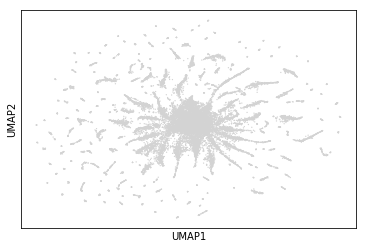

In [11]:
sc.pl.umap(ann_heat)

In [75]:
for thresh in ['0.2', '0.5', '0.8', '0.9']: #['0.8', '0.9', '0.95', '0.99']:
    itime = time.time()
    tmp_cone_clusts = pd.read_csv(_data_path + 'clusterone_clusters_d_{}.tsv'.format(thresh), 
                                  sep="\t", index_col=None, header=None).fillna(value='')
    nclusts = tmp_cone_clusts.shape[0]
    cluster_ndces = {}
    for gname in gene_names:
        cluster_ndces[gname] = np.where(tmp_cone_clusts == gname)[0]
    clust_mmships = np.zeros((len(gene_names), nclusts))
    for i in range(len(gene_names)):
        clust_mmships[i, cluster_ndces[gene_names[i]]] = 1
    clust_mmships = sp.sparse.csr_matrix(clust_mmships)
    sp.sparse.save_npz(_data_path + 'clusterone_memberships_{}.npz'.format(thresh), clust_mmships)
    print ('d = ' + thresh, time.time() - itime)

d = 0.2 31.5933780670166


/miniconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3020: DtypeWarning: Columns (108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255,256,257,258,259,260,261,262,263,264,265,266,267,268,269,270,271,272,273,274,275,276,277,278,279,280,281,282,283,284,285,286,287,288,289,290,291,292,293,294,295,296,297,298,299,300,301,302,303,304,305,306,307,308,309,310,311,312,313,314,315,316,317,318,319,320,321,322,323,324,325,326,327,328,329,330,331,33

d = 0.5 297.12691283226013
d = 0.8 58.87486386299133


/miniconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3020: DtypeWarning: Columns (30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255,256,257,258,259,260,261,262,263,264,265,266,267,268,269,270,271,

d = 0.9 588.5557160377502


Proportion of genes in at least one cluster: 	0.4993762050584099


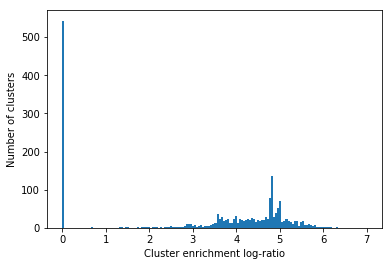

In [81]:
# Weight the matrix edges.
_UNKNOWN_PLACEHOLDER = 'Unknown'
print("Proportion of genes in at least one cluster: \t" + str(np.mean(np.sum(clust_mmships, axis=1) > 0)))
goterms_bycluster = cone_clusts.iloc[:,:10]['Most-enriched GO term'].fillna(_UNKNOWN_PLACEHOLDER)
goenrichments_bycluster = np.log(cone_clusts.iloc[:,:10]['Most-enriched enrichment'].fillna(1))
numterms = len(np.unique(goterms_bycluster))   # Includes an "unknown" term
# Interesting plot of max enrichment strengths
plt.hist(goenrichments_bycluster, bins=150, range=(0,7))
plt.xlabel("Cluster enrichment log-ratio")
plt.ylabel("Number of clusters")
plt.show()

In [6]:
# Build cluster x GO term matrix.
clusterbyGO = sp.sparse.csr_matrix(np.zeros((cone_clusts.shape[0], numterms)))
for i in tqdm.tqdm_notebook(range(numterms)):
    tm = np.unique(goterms_bycluster)[i]
    ndces = np.where(goterms_bycluster == tm)[0]
    clusterbyGO[ndces, i] = np.reshape(np.array(goenrichments_bycluster)[ndces], (len(ndces), 1))

# Combining the two matrices gives total enrichment of each term associated with each gene, combined over the clusters it belongs to.
geneterm_enrichments = clust_mmships.dot(clusterbyGO)
gg_weighted_mat = geneterm_enrichments.dot(geneterm_enrichments.transpose())

<17634x612 sparse matrix of type '<class 'numpy.float64'>'
	with 21422 stored elements in Compressed Sparse Row format>

In [7]:
# Top 20 terms cover ~4k genes; use those to color the graph.
max_goterm_ndces = np.squeeze(np.asarray(geneterm_enrichments.argmax(axis=1)))
num_genes = len(max_goterm_ndces)
max_agg_enrichments_bygene = [geneterm_enrichments[i, max_goterm_ndces[i]] for i in range(num_genes)]
mostenriched_clusters_bygene = np.argmax(clust_mmships.multiply(goenrichments_bycluster).toarray(), axis=1)

# Get the top-enriched terms to use as %colors
sorted_cluster_ndces = np.argsort(goenrichments_bycluster.values)[::-1]

# Define some clusters per Roarke
roarke_cluster_ndces = np.array([735, 352, 290, 1263, 1834, 438, 391, 392, 108, 640, 421, 401, 74]) - 1
roarke_cluster_ndces = roarke_cluster_ndces[:-3]
roarke_clust_mmships = clust_mmships.copy()
roarke_clust_mmships[:, roarke_cluster_ndces] = 0

# Build and save pairwise Jaccard similarities between genes, according to each of the clusterings given.
# gg_jaccsims = pairwise_jaccard_graph(clust_mmships)
# rgg_jaccsims = pairwise_jaccard_graph(roarke_clust_mmships)
# sp.sparse.save_npz(_data_path + 'gg_CO_jaccard.npz', gg_jaccsims)
# sp.sparse.save_npz(_data_path + 'gg_CO_Roarke_jaccard.npz', rgg_jaccsims)

top_cluster_terms = np.unique(np.array(goterms_bycluster)[sorted_cluster_ndces[:30]])#.shape

maxs = np.unique(max_goterm_ndces, return_counts=True)
most_frequent_goterms = maxs[0][np.argsort(maxs[1])[::-1]]  # (Associated with the highest number of genes)
freq_go_term_ndces = most_frequent_goterms[1:][:20]

# Build color vectors over genes, assigning each according to its most-enriched cluster. 
# Optionally only consider a small subset of clusters, e.g. given by Roarke.
c_freqgo_terms = np.array(['Unknown'] * num_genes, dtype='S150')
c_roarke_clusters = np.array(['Unknown'] * num_genes, dtype='S150')
c_topenriched_clusters = np.array(['Unknown'] * num_genes, dtype='S150')

for t in roarke_cluster_ndces:
    c_roarke_clusters[ np.where(mostenriched_clusters_bygene == t)[0] ] = np.array(goterms_bycluster)[t]

for t in sorted_cluster_ndces[:50]:
    c_topenriched_clusters[ np.where(mostenriched_clusters_bygene == t)[0] ] = np.array(goterms_bycluster)[t]

# Make a gene-gene graph

This is a mixture of the following graphs:
- Baseline GLS log-ratios
- Cluster-one graph: edge weight is Jaccard similarity between cluster-one cluster membership sets
- Roarke cluster edge similarity graph: As above, but using just Roarke's clusters

$$\mbox{new graph = } (c \times \mbox{cluster-one membership graph}) + (r \times \mbox{Roarke cluster membership graph}) + ((1-c-r) \times \mbox{GLS p-val graph}) $$
with $0 \leq r, c \leq 1$ being some adjustable weight parameters.

GLS p-values are all $< 0.03$ and the distribution is hugely right skewed, so this is mostly about cluster-one at the moment, just throwing in a little GLS to include the $\sim 2K$ orphan genes that aren't in a cluster into the same connected component.

In [165]:
GLS_pvals_100 = dm.build_knn(fsm, k=100, symmetrize_type='inclusive')
GLS_pvals_10 = dm.build_knn(GLS_pvals_100, k=10, symmetrize_type='inclusive')
GLS_pvals_20_mutual = dm.build_knn(GLS_pvals_100, k=20, symmetrize_type='mutual')

sp.sparse.save_npz(_data_path + 'GLS_pvals_100NN.npz', GLS_pvals_100)
sp.sparse.save_npz(_data_path + 'GLS_pvals_10NN.npz', GLS_pvals_10)
sp.sparse.save_npz(_data_path + 'GLS_pvals_20NN_mutual.npz', GLS_pvals_20_mutual)

GLS_pvals_100 = sp.sparse.load_npz(_data_path + 'GLS_pvals_100NN.npz')
GLS_pvals_10 = sp.sparse.load_npz(_data_path + 'GLS_pvals_10NN.npz')
GLS_pvals_20_mutual = sp.sparse.load_npz(_data_path + 'GLS_pvals_20NN_mutual.npz')

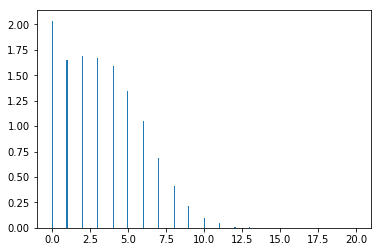

In [419]:
# gm = dm.build_knn(gg_jaccsims, k=50, symmetrize_type='mutual')
# gm_inc = dm.build_knn(gg_jaccsims, k=10, symmetrize_type='inclusive')
# rgm_inc = dm.build_knn(rgg_jaccsims, k=10, symmetrize_type='inclusive')

# sp.sparse.save_npz(_data_path + 'CO_10NN.npz', gm_inc)
# sp.sparse.save_npz(_data_path + 'CO_Roarke_10NN.npz', rgm_inc)

gm_inc = sp.sparse.load_npz(_data_path + 'CO_10NN.npz')
rgm_inc = sp.sparse.load_npz(_data_path + 'CO_Roarke_10NN.npz')

# plt.hist(np.array(gm_inc.sum(axis=1)).flatten(), bins=250, cumulative=False, density=True, range=(0,100))#, range=(10,32))
# plt.hist(np.array(rgm_inc.sum(axis=1)).flatten(), bins=250, cumulative=False, density=True, range=(0,100))
plt.hist(np.array(GLS_pvals_20_mutual.sum(axis=1)).flatten(), bins=250, cumulative=False, density=True)#, range=(0,200))#, range=(10,32))
plt.show()

# Original code for analysis

50 dimensions contain about 1.0000000000000004 fraction of the variance in the first 50 dimensions (t = 0)
Laplacian eigenmap computed. Time: 2.626345634460449
51 dimensions contain about 0.9000000000000006 fraction of the variance in the first 100 dimensions (t = 84.72566533212328)
Diffusion components computed. Time: 7.408616781234741


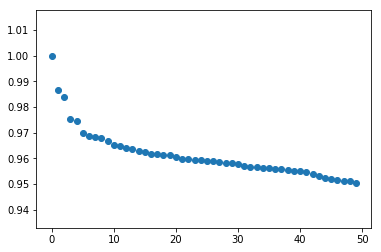

'\n# #Plot 1D projections; they are all standardized!\n# dm.plot_histogram(emap_naive, k=1)\n'

In [450]:
frac_CO_graph = 0.00
frac_RoarkeCO_graph = 0.99
frac_GLS_graph = 1-frac_CO_graph-frac_RoarkeCO_graph

adj_mat = sp.sparse.csr_matrix((frac_CO_graph * gm_inc) + 
                               (frac_RoarkeCO_graph * rgm_inc) + 
                               (frac_GLS_graph * GLS_pvals_10)
                              )
itime = time.time()
n_cmps = 100
reduced_dim = 50

sffix = "_GLS1_CO0"
# sffix = "_GLS01_RC99"
# sffix = "_GLS02_CO49_RC49"
# sffix = "_GLS01_CO99"
vizdf_filename = "{}vizdf{}.csv".format(_data_path, sffix)

"""
Create different eigenmaps:
- Naive: unweighted on all axes.
- Diffmap: scaling each axis by \lambda^{t}
"""
emap_naive, eigvals = dm.diffmap_proj(adj_mat, t=0, n_comps=reduced_dim, embed_type='naive', return_eigvals=True)
print("Laplacian eigenmap computed. Time: {}".format(time.time() - itime))
emap_heat = dm.diffmap_proj(adj_mat, n_comps=n_cmps, n_dims=reduced_dim, min_energy_frac=0.9, embed_type='diffmap', return_eigvals=False)
print("Diffusion components computed. Time: {}".format(time.time() - itime))

plt.scatter(x=range(reduced_dim), y=np.abs(eigvals)[:reduced_dim])
plt.show()

"""
# #Plot 1D projections; they are all standardized!
# dm.plot_histogram(emap_naive, k=1)
"""



In [451]:
# Do t-SNE in diffusion component space.
ann_naive = adata.AnnData(X=emap_naive[:, :40])
ann_heat = adata.AnnData(X=emap_heat[:, :40])
itime = time.time()
sc.tl.tsne(ann_heat, use_rep='X')#, perplexity=30)
print(time.time() - itime)
itime = time.time()
sc.tl.tsne(ann_naive, use_rep='X')
print(time.time() - itime)

90.56874084472656
90.88595914840698


In [452]:
itime = time.time()
sc.pp.neighbors(ann_heat)
print(time.time() - itime)
itime = time.time()
sc.tl.umap(ann_heat)#, perplexity=30)
print(time.time() - itime)

12.910095691680908
25.986040115356445


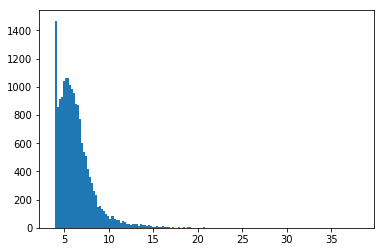

In [442]:
ng = ann_heat.uns['neighbors']['connectivities'].sum(axis=0)
plt.hist(np.squeeze(np.array(ng)), bins=150)
plt.show()

In [453]:
naive_dm = emap_naive[:, :3].copy()
naive_tSNE = np.array(ann_naive.obsm['X_tsne'])
heat_dm = emap_heat[:, :3].copy()
heat_tSNE = np.array(ann_heat.obsm['X_tsne'])

#naive_tSNE = np.array(ann_naive.obsm['X_tsne'])
heat_umap = np.array(ann_heat.obsm['X_umap'])

vizdf = pd.DataFrame(data=np.hstack((naive_dm, naive_tSNE, 
                                     heat_dm, heat_tSNE, heat_umap
                                    )), 
                     columns=['EM_x', 'EM_y', 'EM_z', 'tSNE_x', 'tSNE_y', 
                              'hEM_x', 'hEM_y', 'hEM_z', 'htSNE_x', 'htSNE_y', 'hUMAP_x', 'hUMAP_y'
                             ], dtype='object')

vizdf['roarke_clusters'] = np.array([c.decode('utf-8') for c in c_roarke_clusters])
vizdf['top_enriched_clusters'] = np.array([c.decode('utf-8') for c in c_topenriched_clusters])
vizdf['gene_names'] = gene_names
vizdf['max_enrichments'] = max_agg_enrichments_bygene
vizdf.to_csv(vizdf_filename, sep="\t", index=False)

In [444]:
vizdf = pd.read_csv(vizdf_filename, sep="\t", index_col=False)

In [337]:
data_ess# = data_ess[data_ess.columns[:-4]]   # Only first 481 cols put through GLS, so isolate these
cell_line_names = data_ess.columns
cancer_types = data_ess.columns.str.split('_').str[1:].str.join(' ').str.capitalize().str.replace(
    'Haematopoietic and lymphoid tissue', 'Hematopoietic/lymphoid')
ess_vals = data_ess.values

array([([-12.3058914 ,  66.93685515], [ 1.60697117,  9.84659793]),
       ([ 32.66515103,  -0.49003663], [ 4.37082038, -4.58641859]),
       ([ -2.09695519,   2.85292634], [ 0.96938746,  0.06161546]), ...,
       ([ 18.46029659, -17.87496038], [-3.05329022,  1.81310971]),
       ([ -9.17657836,   0.91736485], [-0.34463399,  0.08713321]),
       ([ -2.41722529,  -1.51948003], [ 0.03055153, -0.98025054])],
      dtype=[('X_tsne', '<f8', (2,)), ('X_umap', '<f8', (2,))]).view(numpy.recarray)

In [340]:
plot_dir = "/users/abalsubr/hodos/coessentiality/working_plots/"
# plotly.offline.plot(build_fig(vizdf, marker_size=marker_size, display_coordinates = { 'x': 'EM_x', 'y': 'EM_y', 'z': 'EM_z' }, custom_colors=brewer_colors), 
#                     filename="{}Naive_EM{}.html".format(plot_dir, sffix), auto_open=False)
# plotly.offline.plot(build_fig(vizdf, marker_size=marker_size, display_coordinates = { 'x': 'tSNE_x', 'y': 'tSNE_y' }, custom_colors=brewer_colors), 
#                     filename="{}naive_tSNE{}.html".format(plot_dir, sffix), auto_open=False)
# plotly.offline.plot(build_fig(vizdf, marker_size=marker_size, display_coordinates = { 'x': 'hEM_x', 'y': 'hEM_y', 'z': 'hEM_z' }, custom_colors=brewer_colors), 
#                     filename="{}Heat_EM{}.html".format(plot_dir, sffix), auto_open=False)
plotly.offline.plot(build_fig(vizdf, marker_size=marker_size, display_coordinates = { 'x': 'htSNE_x', 'y': 'htSNE_y' }, custom_colors=brewer_colors), 
                    filename="{}Heat_tSNE{}.html".format(plot_dir, sffix), auto_open=False)
    
#trace_cells = go.Scatter3d( name=str(idx), x=val['x'], y=val['y'], z=val['z'], hoverinfo='text', text=hover_cells, mode='markers', marker=dict( size=2.5, symbol='circle', colorscale=colorscale) )

'file:///users/abalsubr/hodos/coessentiality/working_plots/Heat_tSNE_GLS02_CO49_RC49.html'

# Checklist
[ ] Top clusterONE cluster genes are close together in the plot

[ ] Genes for separate GO terms clustered separately

# Todos 
- Fix display text.
- Cluster memberships. clusters as points, indicating gene-gene interactions

In [1]:
# Save the notebook to more viewable html form.
!jupyter nbconvert GLS_coess18.ipynb --to html --output coess_viz_code.html

[NbConvertApp] Converting notebook GLS_coess18.ipynb to html
[NbConvertApp] Writing 347008 bytes to coess_viz_code.html


In [122]:
data_ess = pd.read_csv('/users/abalsubr/hodos/coessentiality/data/essentiality.tsv.gz', index_col=0, header=0, sep='\t')

In [128]:
# np.save('/users/abalsubr/hodos/coessentiality/data/essentiality.npy', data_ess.values)
dsv = np.load('/users/abalsubr/hodos/coessentiality/data/essentiality.npy')